<a href="https://colab.research.google.com/github/L1KASA/Computational-Linguistics-NLP/blob/main/lab2/lab_2_6409_%D0%A2%D0%B0%D1%85%D0%BC%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%90%D0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Группа 6409, Тахмазова Анжелика

# Лабораторная работа №2

**Требования:**
* Python >= 3.X

В качестве входных данных к лабораторной работе взят широко известный набор данных IMDB, содержащий 50K обзоров фильмов ([imdb-dataset-of-50k-movie-reviews](https://disk.yandex.ru/i/DDb0zuyUmts5QA)). Откликами являются значения двух классов positive и negative.

In [ ]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import inflect
from google.colab import drive
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

drive.mount('/content/drive/')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive/


In [ ]:
imdb_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdb_data.shape

(50000, 2)

#### Шаг №1 Подготовка данных

Обязательно предобработайте данные!



In [ ]:
def preprocess_text(text):

    # Инициализация лемматизатора
    lemmatizer = WordNetLemmatizer()

    # Инициализация регулярного выражения для удаления чисел
    number_pattern = re.compile(r'\b\d+\b')
    p = inflect.engine()

    # Приведение текста к нижнему регистру
    text = text.lower()

    # Удаление HTML-тегов
    text = re.sub(r'<[^>]+>', ' ', text)

    # Замена чисел на их текстовое представление
    text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

    # Удаление знаков препинания и специальных символов
    text = re.sub(r'[\W_]', ' ', text)

    # Токенизация текста
    tokens = word_tokenize(text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

text = "I've been out since 5, turning up. I'm wasting time, not enough!! :/"

preprocessed_text = preprocess_text(text)

print(preprocessed_text)

since five turning wasting time enough


In [ ]:
imdb_data = imdb_data[:15000]
imdb_data.shape

(15000, 2)

In [ ]:
# Применение предобработки к столбцу review
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Вывод первых пяти строк датасета
print(imdb_data.head())

                                              review  sentiment
0  one reviewer mentioned watching one oz episode...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake think zombie ...          0
4  petter mattei love time money visually stunnin...          1


In [ ]:
X = imdb_data['review']
y = imdb_data['sentiment']

# Разделение данных на обучающую и тестовую выборки (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head(5)

9839     bad one know anything movie get old telling pe...
9680     liked film review mentioned good cast plot int...
7093     yeah unfortunately came across dvd found incre...
11293    plot predictable fighting gun get old definate...
820      seeing dick tracy six ninety nine bin future s...
Name: review, dtype: object

In [ ]:
y_train.head(5)

9839     1
9680     0
7093     0
11293    0
820      1
Name: sentiment, dtype: int64

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [ ]:
vectorizer = CountVectorizer()
x_CountVectorizer = vectorizer.fit_transform(X_train)

#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [ ]:
vectorizer = TfidfVectorizer()
x_TfidfVectorizer = vectorizer.fit_transform(X_train)

#### 3. Компоненты вектора: частоты N-грам.

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
x_Ngram = vectorizer.fit_transform(X_train)

### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))



In [ ]:
# Создаем списки для сохранения результатов
svc_accuracies = []
rfc_accuracies = []

# Модели и методы
models = ['SVC', 'RandomForestClassifier']
methods = ['CountVectorizer', 'TfidfVectorizer', 'Ngrams']
X_data = [x_CountVectorizer, x_TfidfVectorizer, x_Ngram]

In [ ]:
def train_model(X_data, methods, parameters, model_type):
    accuracies = []

    for X, method in zip(X_data, methods):
        print(f"Training model for {method}...")
        # Инициализируем KFold для перекрестной проверки
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Создаем объект GridSearchCV для подбора оптимальных параметров
        clf = GridSearchCV(model_type(), parameters, scoring='accuracy', cv=kf, verbose=3)

        # Обучаем модель
        clf.fit(X, y_train)

        # Инициализируем модель с лучшими параметрами
        cl = model_type(**clf.best_params_)

        # Оценка точности с использованием перекрестной проверки
        accuracy = cross_val_score(cl, X, y_train, scoring='accuracy', verbose=3)

        # Сохраняем точность и параметры модели
        accuracies.append((method, clf.best_params_, accuracy))

    return accuracies

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [ ]:
# Определяем различные параметры для SVC
#parameters_svc = [
#    {'kernel': ['linear'], 'C': [1, 10]},  # Линейное ядро
#    {'kernel': ['rbf'], 'C': [1, 10]}, #, 'gamma': [1, 10]},  # RBF ядро
#    {'kernel': ['poly'], 'C': [1, 10]}, #, 'degree': [2, 5]}  # Полиномиальное ядро
#]

parameters_svc = {'kernel': ['linear', 'poly'], 'C': [1, 10]}

svc_accuracies = train_model(X_data, methods, parameters_svc, SVC)

Training model for CountVectorizer...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.845 total time=  53.1s
[CV 2/5] END ................C=1, kernel=linear;, score=0.831 total time=  52.4s
[CV 3/5] END ................C=1, kernel=linear;, score=0.847 total time=  52.0s
[CV 4/5] END ................C=1, kernel=linear;, score=0.836 total time=  57.3s
[CV 5/5] END ................C=1, kernel=linear;, score=0.852 total time=  52.3s
[CV 1/5] END ..................C=1, kernel=poly;, score=0.694 total time= 1.9min
[CV 2/5] END ..................C=1, kernel=poly;, score=0.792 total time= 1.9min
[CV 3/5] END ..................C=1, kernel=poly;, score=0.657 total time= 1.9min
[CV 4/5] END ..................C=1, kernel=poly;, score=0.767 total time= 1.8min
[CV 5/5] END ..................C=1, kernel=poly;, score=0.766 total time= 1.8min
[CV 1/5] END ...............C=10, kernel=linear;, score=0.845 total time=  51.5s
[CV 2/5] EN

In [ ]:
svc_accuracies

[('CountVectorizer',
  {'C': 10, 'kernel': 'linear'},
  array([0.85291667, 0.83916667, 0.83875   , 0.84208333, 0.845     ])),
 ('TfidfVectorizer',
  {'C': 1, 'kernel': 'linear'},
  array([0.8775    , 0.87375   , 0.8775    , 0.87791667, 0.88416667])),
 ('Ngrams',
  {'C': 1, 'kernel': 'linear'},
  array([0.8175    , 0.82291667, 0.82708333, 0.82291667, 0.83916667]))]

#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [ ]:
# Определяем различные параметры для RandomForestClassifier
parameters_rfc = {
    'n_estimators': [10, 100, 200],  # Количество деревьев
    'max_depth': [1, 10],  # Максимальная глубина деревьев
}

rfc_accuracies = train_model(X_data, methods, parameters_rfc, RandomForestClassifier)

Training model for CountVectorizer...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......max_depth=1, n_estimators=10;, score=0.539 total time=   0.1s
[CV 2/5] END ......max_depth=1, n_estimators=10;, score=0.564 total time=   0.1s
[CV 3/5] END ......max_depth=1, n_estimators=10;, score=0.541 total time=   0.1s
[CV 4/5] END ......max_depth=1, n_estimators=10;, score=0.613 total time=   0.1s
[CV 5/5] END ......max_depth=1, n_estimators=10;, score=0.567 total time=   0.1s
[CV 1/5] END .....max_depth=1, n_estimators=100;, score=0.749 total time=   0.7s
[CV 2/5] END .....max_depth=1, n_estimators=100;, score=0.601 total time=   0.8s
[CV 3/5] END .....max_depth=1, n_estimators=100;, score=0.740 total time=   0.8s
[CV 4/5] END .....max_depth=1, n_estimators=100;, score=0.635 total time=   0.8s
[CV 5/5] END .....max_depth=1, n_estimators=100;, score=0.559 total time=   0.8s
[CV 1/5] END .....max_depth=1, n_estimators=200;, score=0.777 total time=   1.3s
[CV 2/5] EN

In [ ]:
rfc_accuracies

### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [ ]:
# mean для каждой модели и метода
mean_accuracies = {model: {method: [] for method in methods} for model in models}

# Заполнение mean
for i, model in enumerate(models):
    for j, method in enumerate(methods):
        # Определение точностей в зависимости от модели
        if model == 'SVC':
            accuracies = [accuracy for m, params, accuracy in svc_accuracies if m == method]
        elif model == 'RandomForestClassifier':
            accuracies = [accuracy for m, params, accuracy in rfc_accuracies if m == method]
        # Получение средней точности для текущей модели и метода
        mean_accuracies[model][method] = np.mean(accuracies)

# Вывод результатов
for model in models:
    print(f"Модель: {model}")
    for method, accuracy in mean_accuracies[model].items():
        print(f"{method}: {accuracy}")
    print()

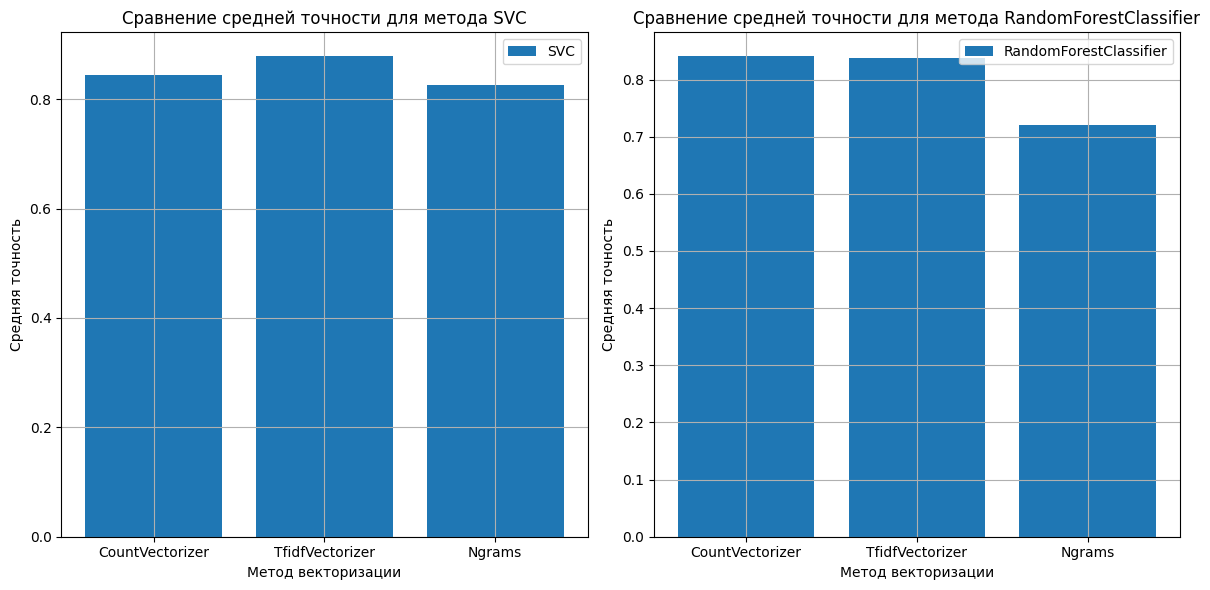

In [ ]:
# Создание графика с двумя подграфиками
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Для каждой модели
for ax, (model, accuracies) in zip(axes, mean_accuracies.items()):
    # Создание столбчатой диаграммы для каждой модели
    ax.bar(np.arange(len(methods)), list(accuracies.values()), label=model)

    # Установка меток по оси x
    ax.set_xticks(np.arange(len(methods)))
    ax.set_xticklabels(methods)

    # Установка названия оси x
    ax.set_xlabel('Метод векторизации')

    # Установка названия оси y
    ax.set_ylabel('Средняя точность')

    # Установка заголовка для графика
    ax.set_title(f'Сравнение средней точности для метода {model}')

    # Добавление сетки на график
    ax.grid(True)

# Добавление легенды для графиков
axes[0].legend()
axes[1].legend()

# Автоматическое выравнивание расположения элементов на графике
plt.tight_layout()

# Отображение графика
plt.show()